In [1]:
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy.stats import linregress
from scipy.spatial import distance
from matplotlib import colors
import scipy
import os
from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.decomposition import PCA
from ast import literal_eval
# sns.set()
# sns.set_context('talk')
# sns.set(font="Avenir")
sns.set_color_codes()
sns.set_style('white')
sns.set_style('ticks')
# sns.set_style({'font.family': 'Avenir'})

In [114]:
def ravel_x(x,rate,rows,columns,bcs,nonzero_indices,fixed_rate):
    
    l = []
    
    for bc in range(bcs):
        print(x[bc])
        l = l + list(np.r_[x[bc].ravel()[nonzero_indices]])
    
    if not fixed_rate:
        l = l + [rate]
    
    return l 

def unravel_x(flat,rows,columns,bcs,nonzero_indices,fixed_rate):
    
    nonzero_len = len(nonzero_indices)
    x_full = []
    
    for bc in range(bcs):
    
        x = np.zeros((rows,columns))
        np.put(x,nonzero_indices,flat[nonzero_len*(bc):nonzero_len*(bc+1)+1])
        x_full.append(x)
        
    if not fixed_rate:
        return x_full, flat[-1]
    else:
        return x_full, fixed_rate


def correction(x_flat,y,rows,columns,bcs,nonzero_indices,fixed_rate):
    
    x, rate = unravel_x(x_flat,rows,columns,bcs,nonzero_indices,fixed_rate)
    
    leastsq = 0
    for bc in range(bcs):
        row_sums =  np.tile(np.sum(x[bc],axis=0),(rows,1))
        column_sums = np.tile(np.sum(x[bc],axis=1),(columns,1)).T
        exp_y = (1-rate)*x[bc] + rate*row_sums + rate*column_sums
    
        leastsq += np.sum((y[bc] - exp_y)**2)
    
    return leastsq

In [28]:
real_pair = {'P104':{'P101':True,'P108':False,'P109':False,'P110':False,'P126':False,'P127':False,'P128':False,'P129':False},
        'P105':{'P101':False,'P108':True,'P109':False,'P110':True,'P126':True,'P127':True,'P128':True,'P129':True},
         'P111':{'P101':False,'P108':False,'P109':True,'P110':False,'P126':True,'P127':True,'P128':True,'P129':True},
         'P112':{'P101':False,'P108':True,'P109':True,'P110':True,'P126':False,'P127':True,'P128':True,'P129':True},
         'P122':{'P101':False,'P108':True,'P109':True,'P110':True,'P126':True,'P127':False,'P128':True,'P129':True},
         'P123':{'P101':False,'P108':True,'P109':True,'P110':True,'P126':True,'P127':True,'P128':False,'P129':True},
         'P124':{'P101':False,'P108':True,'P109':True,'P110':True,'P126':True,'P127':True,'P128':True,'P129':True},
         'P125':{'P101':False,'P108':False,'P109':True,'P110':True,'P126':True,'P127':True,'P128':True,'P129':True},
         'P130':{'P101':False,'P108':True,'P109':True,'P110':True,'P126':True,'P127':True,'P128':True,'P129':True},
         'P131':{'P101':False,'P108':False,'P109':False,'P110':False,'P126':False,'P127':True,'P128':True,'P129':False},
         'P132':{'P101':False,'P108':False,'P109':False,'P110':True,'P126':True,'P127':False,'P128':False,'P129':False},
         'P133':{'P101':False,'P108':True,'P109':True,'P110':False,'P126':False,'P127':False,'P128':False,'P129':False}
        }
pair_list = []  

for k,l in real_pair.items():
    
    pair_list.append([i for k,i in l.items()])
    
reads_df = p.read_table('BB_051118_allindices.tab',sep='    ')
reads = {}
for fwd in np.unique(reads_df['FwdPrimer'].values):
    reads[fwd] = {}
    for rev in np.unique(reads_df['RevPrimer'].values):
#         print(fwd,rev)
        this_pair = reads_df[(reads_df['FwdPrimer'].isin([fwd]) & (reads_df['RevPrimer'].isin([rev])))]
        if len(this_pair) > 0:
            reads[fwd][rev] = this_pair['Reads'].values[0]
        else:
            reads[fwd][rev] = 0

primer_indices = p.read_table('sampleindexfile_BB_051118_allindices.txt',names=['Sample','FwdPrimer','RevPrimer'])            

venkataram = p.read_csv('VenkataramData.csv')
venkataram_bcs = list(venkataram[venkataram['500pool_t_2_Rep_3'].notna()]['barcode'].values)
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]
# spike_iras = []
bc_pool = venkataram_bcs + neutral_spikes

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [4]:
bb1 = p.read_table('BB1_condensedBarcodeCounts.tab')
ira_duplicates = {}
bc_list = []
for bc in bb1['barcode'].values:
    if type(bc) != int:
        bc_list.append(int(bc.split('/')[0]))
        if np.any(np.asarray([int(i) for i in bc.split('/')]) > 494067):
            print(np.asarray([int(i) for i in bc.split('/')]))
            j = bc.split('/')[np.where(np.asarray([int(i) for i in bc.split('/')]) > 494067)[0][0]]
            ira_duplicates[j] = int(bc.split('/')[0])
    else:
        bc_list.append(bc)
bb1['barcode'] = bc_list
bb1 = bb1[bb1['barcode'].isin(bc_pool)]
bb1 = bb1.sort_values('barcode')

bb2 = p.read_table('BB2_allindices_condensedBarcodeCounts.tab')
ira_duplicates = {}
bc_list = []
for bc in bb2['barcode'].values:
    if type(bc) != int:
        bc_list.append(int(bc.split('/')[0]))
        if np.any(np.asarray([int(i) for i in bc.split('/')]) > 494067):
            print(np.asarray([int(i) for i in bc.split('/')]))
            j = bc.split('/')[np.where(np.asarray([int(i) for i in bc.split('/')]) > 494067)[0][0]]
            ira_duplicates[j] = int(bc.split('/')[0])
    else:
        bc_list.append(bc)
bb2['barcode'] = bc_list
bb2 = bb2[bb2['barcode'].isin(bc_pool)]
bb2 = bb2.sort_values('barcode')

[ 28740 494096]
[152283 494070]
[428484 494085]
[ 94935 494069]
[220685 494091]
[ 49275 494075]
[156431 494087]
[  1379 472221 477096 494094]
[284204 494086]
[ 85670 494077]
[ 42069 494081]
[480303 494076]
[206239 494079]
[433166 494073]
[178258 494072]
[   151 458480 494093]
[317298 494090]
[168053 494080]
[ 18420 494095]
[271777 494082]
[ 81644 494089]
[ 10015 494092]
[ 13444 494083]
[319806 494084]
[431418 494074]
[129028 494078]
[158030 494068]
[ 48317 494088]
[ 28740 408695 494096]
[ 18420 357514 494095]
[152283 494070]
[428484 494085]
[ 94935 494069]
[220685 494091]
[ 49275 494075]
[271777 403192 494082]
[156431 494087]
[  1379 412217 472221 477096 494094]
[284204 494086]
[ 85670 494077]
[ 42069 494081]
[273106 480303 494076]
[206239 494079]
[433166 494073]
[178258 494072]
[   151 458480 494093]
[317298 494090]
[168053 494080]
[ 81644 494089]
[ 10015 494092]
[ 13444 494083]
[319806 494084]
[431418 494074]
[129028 494078]
[158030 494068]
[ 48317 494088]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
master_list = []
for bc in range(len(bb2['barcode'].values)):
#     master_list.append([])
    this_bc = np.zeros((len(real_pair.keys()),len(real_pair['P104'].keys())))
    for f in range(len(real_pair.keys())):
        for r in range(len(real_pair['P104'].keys())):
            fwd = list(real_pair.keys())[f]
            rev = list(real_pair[fwd].keys())[r]
            sample_id = primer_indices[(primer_indices['FwdPrimer']==fwd) & (primer_indices['RevPrimer']==rev)]['Sample'].values[0]
            
            this_bc[f][r] = bb2[sample_id].values[bc]
            
    master_list.append(this_bc)

In [26]:
[np.sum(master_list,axis=0)][0]

array([[ 7585865.,   103088.,   112986.,   163307.,   130159.,   187765.,
          185456.,   133585.],
       [  121683.,  3141179.,   398573.,  6598310.,  5911067.,  2759347.,
         2220852.,   856418.],
       [  105561.,   277421.,  1983724.,   446142.,   983616.,  2183547.,
         2369487.,   819653.],
       [   96497.,   411684.,   698983.,  4771458.,   369250.,  2700656.,
         1784276.,   652496.],
       [  103488.,   550208.,   581516.,  2195752.,  6660462.,   699287.,
         1710577.,   781742.],
       [  139258.,   554619.,   789505.,   962536.,  1095305., 13706749.,
          626617.,   488930.],
       [  137847.,   487702.,   427199.,   921001.,   841398.,  1257242.,
         8438380.,   982815.],
       [   97729.,   304619.,   411992.,   842802.,   750103.,  1323272.,
         1294423.,  8235406.],
       [   70751.,   269332.,   287617.,   606099.,   505522.,  4081556.,
          840345.,   275487.],
       [   99662.,   166900.,   156799.,   270866.,   2

In [30]:
nonzero_indices

[0]

In [31]:
real_pair

{'P104': {'P101': True,
  'P108': False,
  'P109': False,
  'P110': False,
  'P126': False,
  'P127': False,
  'P128': False,
  'P129': False},
 'P105': {'P101': False,
  'P108': True,
  'P109': False,
  'P110': True,
  'P126': True,
  'P127': True,
  'P128': True,
  'P129': True},
 'P111': {'P101': False,
  'P108': False,
  'P109': True,
  'P110': False,
  'P126': True,
  'P127': True,
  'P128': True,
  'P129': True},
 'P112': {'P101': False,
  'P108': True,
  'P109': True,
  'P110': True,
  'P126': False,
  'P127': True,
  'P128': True,
  'P129': True},
 'P122': {'P101': False,
  'P108': True,
  'P109': True,
  'P110': True,
  'P126': True,
  'P127': False,
  'P128': True,
  'P129': True},
 'P123': {'P101': False,
  'P108': True,
  'P109': True,
  'P110': True,
  'P126': True,
  'P127': True,
  'P128': False,
  'P129': True},
 'P124': {'P101': False,
  'P108': True,
  'P109': True,
  'P110': True,
  'P126': True,
  'P127': True,
  'P128': True,
  'P129': True},
 'P125': {'P101': Fals

In [123]:
### First find expected switching rate for the total number of reads

nonzero_indices = [i for i in range(len(np.asarray(pair_list).ravel())) if np.asarray(pair_list).ravel()[i]]


bcs = 1
rows = len(real_pair.keys())
columns = len(real_pair['P104'].keys())
x = [np.sum(master_list,axis=0)]
print(x)
y = [np.sum(master_list,axis=0)]
rate = 0.1
flat_x = ravel_x(x,rate,rows,columns,bcs,nonzero_indices,False)

outcome = scipy.optimize.minimize(correction,flat_x,args=(y,rows,columns,bcs,nonzero_indices,False))

[array([[ 7585865.,   103088.,   112986.,   163307.,   130159.,   187765.,
          185456.,   133585.],
       [  121683.,  3141179.,   398573.,  6598310.,  5911067.,  2759347.,
         2220852.,   856418.],
       [  105561.,   277421.,  1983724.,   446142.,   983616.,  2183547.,
         2369487.,   819653.],
       [   96497.,   411684.,   698983.,  4771458.,   369250.,  2700656.,
         1784276.,   652496.],
       [  103488.,   550208.,   581516.,  2195752.,  6660462.,   699287.,
         1710577.,   781742.],
       [  139258.,   554619.,   789505.,   962536.,  1095305., 13706749.,
          626617.,   488930.],
       [  137847.,   487702.,   427199.,   921001.,   841398.,  1257242.,
         8438380.,   982815.],
       [   97729.,   304619.,   411992.,   842802.,   750103.,  1323272.,
         1294423.,  8235406.],
       [   70751.,   269332.,   287617.,   606099.,   505522.,  4081556.,
          840345.,   275487.],
       [   99662.,   166900.,   156799.,   270866.,   

In [124]:
corrected_total, total_rate = unravel_x(outcome.x,rows,columns,1,nonzero_indices,False)

In [127]:
print(np.sum(corrected_total),np.sum(master_list),total_rate)

105792439.43937537 123865335.0 0.019250075515263775


In [128]:
nonzero_indices = [i for i in range(len(np.asarray(pair_list).ravel())) if np.asarray(pair_list).ravel()[i]]
bcs = 1
rows = len(real_pair.keys())
columns = len(real_pair['P104'].keys())

# rate = 0.01

outcomes = []

for bc in range(len(bb2['barcode'].values)):
    x = [master_list[bc]]
    y = [master_list[bc]]
    flat_x = ravel_x(x,rate,rows,columns,bcs,nonzero_indices,total_rate)
    outcome = scipy.optimize.minimize(correction,flat_x,args=(y,rows,columns,bcs,nonzero_indices,total_rate))
    
    outcomes.append(unravel_x(outcome.x,rows,columns,bcs,nonzero_indices,total_rate)[0])

[[3.056e+03 5.400e+01 5.800e+01 8.500e+01 4.500e+01 5.200e+01 6.400e+01
  5.000e+01]
 [6.300e+01 4.915e+03 2.320e+02 5.238e+03 1.827e+03 5.600e+02 4.350e+02
  7.030e+02]
 [4.600e+01 1.840e+02 3.042e+03 2.370e+02 3.090e+02 7.060e+02 4.450e+02
  7.440e+02]
 [5.900e+01 4.490e+02 6.850e+02 3.617e+03 1.490e+02 1.029e+03 2.490e+02
  5.220e+02]
 [4.200e+01 6.030e+02 4.860e+02 1.668e+03 1.907e+03 3.230e+02 2.660e+02
  7.460e+02]
 [5.200e+01 5.540e+02 6.440e+02 6.830e+02 3.920e+02 4.281e+03 1.840e+02
  3.290e+02]
 [7.200e+01 3.780e+02 3.090e+02 6.760e+02 2.200e+02 5.340e+02 2.486e+03
  5.340e+02]
 [3.600e+01 1.500e+02 2.410e+02 4.720e+02 1.790e+02 5.010e+02 2.120e+02
  1.122e+03]
 [4.600e+01 3.510e+02 3.280e+02 2.940e+02 2.590e+02 4.643e+03 7.320e+02
  1.820e+02]
 [3.500e+01 8.800e+01 6.000e+01 1.180e+02 6.700e+01 8.980e+02 2.210e+02
  6.400e+01]
 [5.000e+00 3.900e+01 3.400e+01 4.300e+02 1.220e+02 5.900e+01 2.600e+01
  2.400e+01]
 [9.000e+00 1.850e+02 3.460e+02 6.900e+01 2.600e+01 5.300e+01 4.6

[[2959.   43.   39.   50.   48.   66.   65.   47.]
 [  52. 4586.  204. 4625. 1603.  477.  300.  635.]
 [  36.  162. 2807.  202.  239.  552.  320.  603.]
 [  48.  347.  473. 3266.  115.  873.  191.  455.]
 [  40.  492.  395. 1303. 1578.  246.  205.  653.]
 [  47.  447.  522.  521.  274. 3875.  181.  270.]
 [  69.  265.  218.  539.  173.  376. 2379.  437.]
 [  22.  104.  185.  359.  141.  421.  169. 1024.]
 [  32.  286.  285.  219.  207. 4439.  638.  138.]
 [  23.   56.   60.   93.   43.  740.  137.   54.]
 [  14.   31.   34.  314.   84.   46.   25.   35.]
 [  10.  123.  276.   45.   14.   53.   23.   44.]]
[[ 1.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  2.  1.  0.  1.  1.  1.  0.]
 [ 0.  0. 17.  0.  0.  0.  0.  0.]
 [ 0.  3.  0.  2.  0.  0.  0.  1.]
 [ 0.  3.  4.  2.  1.  0.  0.  0.]
 [ 0.  5.  3.  1.  8.  1.  0.  1.]
 [ 0.  1.  1.  0.  0.  2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  2.  2.  2.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  0.]
 [ 0.  1.  1.  1.  0.  0.  0.  0.]
 [

[[3.1010e+04 3.6000e+02 3.8500e+02 5.8400e+02 4.3600e+02 7.1300e+02
  6.5200e+02 4.5500e+02]
 [3.7500e+02 1.0298e+04 9.7200e+02 2.4492e+04 1.4559e+04 6.2190e+03
  4.4960e+03 2.6540e+03]
 [3.5800e+02 6.5600e+02 6.3630e+03 1.2580e+03 2.2610e+03 7.6200e+03
  5.2060e+03 2.7310e+03]
 [3.2000e+02 1.0030e+03 2.3800e+03 2.0916e+04 1.0510e+03 9.9730e+03
  5.3440e+03 2.0520e+03]
 [3.7900e+02 1.6780e+03 1.6860e+03 8.0410e+03 1.7161e+04 2.3380e+03
  5.0690e+03 2.6890e+03]
 [4.9900e+02 1.7080e+03 2.5150e+03 3.4950e+03 2.9500e+03 5.4955e+04
  1.9690e+03 1.3630e+03]
 [4.4600e+02 1.6440e+03 1.2140e+03 3.4930e+03 2.4100e+03 4.7920e+03
  3.2339e+04 3.6720e+03]
 [2.6600e+02 5.9500e+02 8.8900e+02 2.5850e+03 1.5340e+03 4.0460e+03
  2.6630e+03 1.8463e+04]
 [2.1700e+02 7.6500e+02 7.1800e+02 1.3960e+03 1.0580e+03 1.4745e+04
  2.8180e+03 7.0000e+02]
 [3.6100e+02 3.8300e+02 3.5100e+02 8.0800e+02 5.1900e+02 8.3680e+03
  3.2520e+03 4.7200e+02]
 [6.6000e+01 1.1600e+02 1.4000e+02 1.8970e+03 1.1810e+03 3.9000e+02
  

[[ 4610.    60.    67.   113.    98.   101.   127.    96.]
 [  103.  3137.   488.  4384. 10049.  2773.  2251.   799.]
 [   83.   297.  1749.   449.  1544.  1214.  2114.   818.]
 [   72.   388.   883.  3259.   385.  1402.  1670.   668.]
 [   95.   657.   885.  1784. 12278.   618.  1591.   793.]
 [   93.   453.  1222.   676.  1593.  6138.   453.   453.]
 [   85.   469.   478.   645.  1135.   759.  3726.   643.]
 [  100.   418.   681.   855.  1299.  1070.  1519. 11880.]
 [   54.   271.   275.   648.   438.  3537.   785.   256.]
 [   63.   134.   145.   230.   253.   965.  1581.   204.]
 [   16.    72.    64.   339.   930.   108.    75.    80.]
 [   21.   176.   704.   118.    76.   109.   109.    92.]]
[[1414.   32.   33.   49.   18.   48.   29.   29.]
 [  40. 3268.  200. 2549.  870.  308.  199.  462.]
 [  23.  120. 2170.  162.  199.  339.  154.  468.]
 [  33.  358.  487. 1931.  118.  494.  130.  351.]
 [  39.  403.  331.  908.  958.  190.  167.  491.]
 [  38.  426.  492.  395.  245. 1782

[[3351.   56.   66.   71.   44.   76.   63.   77.]
 [  67. 5269.  277. 5259. 1795.  562.  404.  810.]
 [  44.  205. 3403.  296.  295.  766.  362.  823.]
 [  54.  476.  692. 3977.  193. 1066.  259.  622.]
 [  41.  579.  474. 1750. 1882.  336.  286.  804.]
 [  77.  615.  681.  656.  377. 4530.  224.  327.]
 [  68.  397.  336.  745.  222.  553. 2565.  532.]
 [  44.  160.  239.  543.  213.  524.  222. 1115.]
 [  46.  347.  367.  300.  252. 4798.  821.  203.]
 [  44.   84.   60.  125.   64.  793.  199.   79.]
 [  10.   36.   44.  466.  106.   59.   34.   34.]
 [   8.  214.  412.   75.   28.   90.   45.   50.]]
[[22581.   296.   358.   502.   390.   563.   574.   392.]
 [  300.  6772.   926. 10828. 18621.  8188.  5434.  2053.]
 [  245.   569.  4055.  1072.  2715.  5112.  6129.  1832.]
 [  268.   842.  1885. 13514.  1039.  5994.  5605.  1668.]
 [  314.  1361.  1603.  5579. 25835.  1835.  5169.  2025.]
 [  412.  1136.  2294.  2131.  3471. 31889.  1651.  1220.]
 [  316.  1117.   932.  1991.  23

[[1918.   28.   47.   53.   29.   62.   52.   49.]
 [  43. 4057.  221. 3531. 1205.  406.  283.  565.]
 [  31.  154. 2504.  215.  221.  474.  246.  557.]
 [  32.  395.  488. 2470.  128.  648.  172.  439.]
 [  34.  455.  353. 1048. 1314.  237.  178.  577.]
 [  31.  456.  548.  472.  246. 2687.  141.  238.]
 [  51.  251.  234.  470.  156.  306. 1549.  359.]
 [  11.  111.  185.  301.  146.  331.  123.  760.]
 [  29.  274.  258.  193.  190. 3682.  604.  146.]
 [  26.   55.   33.   91.   31.  501.  113.   44.]
 [   8.   34.   36.  259.   74.   39.   37.   24.]
 [   9.  133.  308.   60.   33.   67.   33.   31.]]
[[ 64158.    812.    863.   1440.   1049.   1566.   1527.   1063.]
 [   966.  26715.   3048.  75268.  38196.  17158.  13510.   8235.]
 [   887.   2222.  16006.   4129.   7156.  19997.  15732.   8536.]
 [   873.   3516.   7720.  46807.   3188.  25547.  14957.   5984.]
 [   874.   5258.   5305.  23527.  40248.   6464.  15089.   7681.]
 [  1286.   5115.   7002.  10362.   8473. 122564.   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[[1.07782e+05 1.21700e+03 1.35300e+03 1.91000e+03 1.84400e+03 2.62800e+03
  2.86900e+03 1.77300e+03]
 [1.90500e+03 2.27770e+04 4.83400e+03 7.53030e+04 1.16431e+05 5.24790e+04
  4.45620e+04 9.56500e+03]
 [1.50300e+03 2.84100e+03 1.34630e+04 5.05300e+03 1.69590e+04 3.13690e+04
  4.80670e+04 8.56400e+03]
 [1.27800e+03 2.98800e+03 5.63300e+03 5.07360e+04 5.12700e+03 3.83450e+04
  3.09340e+04 6.53300e+03]
 [1.63600e+03 4.72800e+03 6.14900e+03 2.51230e+04 1.37583e+05 1.10170e+04
  3.07350e+04 7.98800e+03]
 [2.11700e+03 5.00300e+03 8.71900e+03 1.07430e+04 1.83460e+04 2.19452e+05
  1.13870e+04 6.59700e+03]
 [1.96300e+03 4.44600e+03 4.16300e+03 9.29500e+03 1.30930e+04 1.66960e+04
  1.31500e+05 1.15450e+04]
 [1.58400e+03 3.71600e+03 4.92800e+03 9.82800e+03 1.27380e+04 1.83300e+04
  2.34460e+04 1.87994e+05]
 [1.03000e+03 1.71200e+03 2.01100e+03 6.92200e+03 6.20100e+03 3.59640e+04
  1.01060e+04 3.74500e+03]
 [1.43500e+03 1.79000e+03 1.73900e+03 3.14900e+03 3.46100e+03 2.67630e+04
  3.31030e+04 2.9

[[1.19662e+05 1.40700e+03 1.54700e+03 2.37000e+03 1.94000e+03 2.66400e+03
  2.68800e+03 1.88800e+03]
 [1.59700e+03 1.92010e+04 4.14000e+03 7.67680e+04 7.31450e+04 3.78400e+04
  2.81330e+04 7.53600e+03]
 [1.50600e+03 2.78200e+03 1.20300e+04 5.09800e+03 1.13250e+04 3.10430e+04
  3.11880e+04 7.72100e+03]
 [1.23000e+03 3.58000e+03 6.21500e+03 5.97320e+04 4.61600e+03 3.82000e+04
  2.69400e+04 6.19200e+03]
 [1.34000e+03 4.48200e+03 5.23300e+03 2.40610e+04 8.44080e+04 9.04600e+03
  2.63220e+04 6.52800e+03]
 [2.08800e+03 5.39400e+03 7.49000e+03 1.11970e+04 1.41650e+04 2.25762e+05
  8.73400e+03 5.40800e+03]
 [1.92500e+03 5.17200e+03 4.54600e+03 1.04580e+04 1.05150e+04 1.71800e+04
  1.42993e+05 1.15390e+04]
 [1.36500e+03 3.53700e+03 4.35200e+03 9.86100e+03 9.20800e+03 1.86520e+04
  1.77010e+04 1.05974e+05]
 [8.02000e+02 1.74400e+03 2.04500e+03 6.53500e+03 5.88500e+03 3.62210e+04
  7.90500e+03 2.67900e+03]
 [1.52100e+03 1.90800e+03 1.87200e+03 3.46500e+03 2.92500e+03 2.96820e+04
  2.20700e+04 2.4

[[24999.   349.   361.   545.   432.   673.   664.   474.]
 [  435.  6450.  1410. 20308. 27771. 10535.  8574.  2487.]
 [  317.   764.  3857.  1328.  4110.  5815.  8382.  2219.]
 [  313.   965.  1802. 13913.  1303.  6996.  6726.  1689.]
 [  395.  1526.  1975.  6206. 31802.  2346.  6752.  2164.]
 [  422.  1308.  2484.  2742.  4633. 39815.  2063.  1500.]
 [  413.  1262.  1165.  2418.  3186.  3267. 25219.  2622.]
 [  336.  1045.  1443.  2602.  3065.  3874.  4713. 37448.]
 [  269.   624.   733.  2491.  1766. 11223.  2416.   965.]
 [  319.   464.   487.   782.   845.  5276.  6124.   641.]
 [   60.   168.   207.  1323.  2326.   405.   392.   251.]
 [   53.   238.  1166.   222.   175.   327.   316.   170.]]
[[2.455e+03 4.800e+01 4.400e+01 5.200e+01 3.800e+01 4.600e+01 5.500e+01
  4.800e+01]
 [4.600e+01 4.405e+03 2.530e+02 4.396e+03 1.489e+03 5.170e+02 3.680e+02
  7.180e+02]
 [3.900e+01 1.830e+02 2.571e+03 2.440e+02 3.050e+02 7.050e+02 3.350e+02
  6.860e+02]
 [4.900e+01 4.330e+02 7.060e+02 2.87

[[9.18950e+04 1.09600e+03 1.16900e+03 1.97500e+03 1.93400e+03 2.45700e+03
  2.68600e+03 1.69300e+03]
 [1.74300e+03 2.04980e+04 5.18100e+03 7.31830e+04 1.05771e+05 5.34560e+04
  4.59130e+04 1.02510e+04]
 [1.47000e+03 3.50600e+03 1.18880e+04 6.08000e+03 1.87570e+04 3.33570e+04
  5.12750e+04 8.95800e+03]
 [1.21400e+03 3.63800e+03 6.65600e+03 4.59210e+04 5.54600e+03 3.93030e+04
  3.08830e+04 7.15200e+03]
 [1.46900e+03 5.16000e+03 6.99100e+03 2.58580e+04 1.20365e+05 1.06600e+04
  3.03300e+04 8.17200e+03]
 [1.82300e+03 5.17300e+03 9.18500e+03 1.21020e+04 2.01380e+04 1.95395e+05
  1.10170e+04 6.40500e+03]
 [1.68000e+03 4.99700e+03 4.95800e+03 1.02960e+04 1.44840e+04 1.77790e+04
  1.12389e+05 1.23860e+04]
 [1.56100e+03 4.34400e+03 5.85200e+03 1.13160e+04 1.41790e+04 1.98860e+04
  2.57350e+04 1.61189e+05]
 [9.32000e+02 2.23600e+03 2.72900e+03 1.17010e+04 9.16800e+03 3.34470e+04
  1.07300e+04 4.53800e+03]
 [1.34700e+03 2.12500e+03 2.15900e+03 3.70900e+03 3.86900e+03 2.86360e+04
  3.39680e+04 3.0

[[2.341e+03 4.800e+01 4.900e+01 5.000e+01 3.300e+01 6.000e+01 4.300e+01
  3.200e+01]
 [5.000e+01 1.875e+03 1.660e+02 3.320e+03 1.269e+03 5.510e+02 3.970e+02
  3.470e+02]
 [3.100e+01 1.010e+02 1.393e+03 1.930e+02 2.230e+02 7.160e+02 4.790e+02
  3.870e+02]
 [3.800e+01 2.020e+02 3.480e+02 2.556e+03 1.200e+02 1.039e+03 3.400e+02
  3.150e+02]
 [3.300e+01 2.950e+02 2.450e+02 1.065e+03 1.344e+03 2.640e+02 3.750e+02
  4.630e+02]
 [4.000e+01 3.190e+02 3.170e+02 4.970e+02 3.210e+02 4.556e+03 1.760e+02
  1.870e+02]
 [5.300e+01 2.420e+02 1.900e+02 4.940e+02 1.800e+02 4.790e+02 2.839e+03
  4.440e+02]
 [3.200e+01 9.300e+01 1.120e+02 3.330e+02 1.510e+02 4.120e+02 2.250e+02
  1.142e+03]
 [3.000e+01 1.830e+02 1.640e+02 1.890e+02 1.340e+02 2.266e+03 3.960e+02
  9.000e+01]
 [2.100e+01 4.800e+01 4.300e+01 1.020e+02 4.400e+01 8.020e+02 2.550e+02
  6.300e+01]
 [6.000e+00 1.200e+01 1.600e+01 2.660e+02 8.400e+01 4.100e+01 3.000e+01
  2.100e+01]
 [4.000e+00 8.800e+01 1.470e+02 3.300e+01 1.900e+01 4.600e+01 2.6

[[1.730e+03 3.500e+01 2.700e+01 3.700e+01 3.800e+01 4.200e+01 4.600e+01
  2.400e+01]
 [3.000e+01 2.545e+03 1.420e+02 2.634e+03 8.500e+02 2.660e+02 2.130e+02
  3.100e+02]
 [2.400e+01 1.210e+02 1.868e+03 1.480e+02 1.540e+02 3.700e+02 1.560e+02
  4.150e+02]
 [2.500e+01 1.990e+02 3.270e+02 2.186e+03 7.400e+01 5.000e+02 1.540e+02
  2.780e+02]
 [2.200e+01 3.380e+02 2.460e+02 7.280e+02 8.740e+02 1.420e+02 1.430e+02
  3.270e+02]
 [3.000e+01 2.850e+02 3.690e+02 2.940e+02 1.640e+02 1.912e+03 1.200e+02
  1.620e+02]
 [4.900e+01 1.860e+02 1.610e+02 2.990e+02 1.120e+02 2.580e+02 1.414e+03
  2.490e+02]
 [1.700e+01 8.000e+01 1.130e+02 2.720e+02 8.900e+01 2.530e+02 1.050e+02
  5.280e+02]
 [2.600e+01 1.880e+02 2.030e+02 1.450e+02 1.360e+02 2.379e+03 3.890e+02
  9.100e+01]
 [2.000e+01 4.100e+01 2.600e+01 6.100e+01 3.300e+01 3.420e+02 8.500e+01
  2.600e+01]
 [2.000e+00 2.600e+01 3.000e+01 2.020e+02 5.700e+01 2.300e+01 2.400e+01
  2.300e+01]
 [5.000e+00 9.100e+01 1.760e+02 3.900e+01 3.200e+01 4.100e+01 1.8

[[7.2380e+03 1.0500e+02 1.0700e+02 1.6200e+02 1.1300e+02 1.8700e+02
  1.6900e+02 1.3400e+02]
 [1.1900e+02 5.3380e+03 3.8900e+02 8.1020e+03 3.6420e+03 1.3310e+03
  8.6900e+02 9.5100e+02]
 [7.8000e+01 2.9700e+02 3.5870e+03 4.7700e+02 6.2300e+02 2.0560e+03
  1.2490e+03 1.0410e+03]
 [1.0300e+02 5.8500e+02 8.7600e+02 6.5850e+03 3.8500e+02 3.0680e+03
  8.3300e+02 9.3800e+02]
 [9.5000e+01 7.3500e+02 6.3600e+02 2.7660e+03 3.7050e+03 6.5200e+02
  7.2000e+02 1.1080e+03]
 [1.6300e+02 7.5300e+02 9.0600e+02 1.2050e+03 8.5600e+02 1.2752e+04
  5.0000e+02 5.0500e+02]
 [1.5400e+02 5.6800e+02 5.2700e+02 1.2290e+03 5.5800e+02 1.3310e+03
  7.5670e+03 1.2320e+03]
 [7.7000e+01 2.4600e+02 3.8800e+02 8.9100e+02 4.7000e+02 1.1650e+03
  6.2800e+02 2.9850e+03]
 [6.7000e+01 4.0500e+02 3.9100e+02 4.5700e+02 4.0800e+02 5.8330e+03
  1.0870e+03 2.6400e+02]
 [9.5000e+01 1.8800e+02 1.6200e+02 2.6600e+02 1.5600e+02 2.3370e+03
  6.4300e+02 1.5800e+02]
 [1.7000e+01 6.0000e+01 6.5000e+01 6.1500e+02 2.5500e+02 9.2000e+01
  

[[2912.   49.   56.   67.   29.   71.   69.   57.]
 [  53. 4820.  273. 5881. 1635.  540.  395.  704.]
 [  43.  209. 2938.  264.  301.  640.  355.  783.]
 [  68.  466.  697. 3861.  186.  976.  285.  504.]
 [  43.  559.  445. 1591. 1686.  341.  290.  744.]
 [  47.  633.  609.  705.  375. 3958.  239.  375.]
 [  73.  373.  329.  718.  216.  545. 2475.  564.]
 [  31.  135.  230.  526.  208.  591.  219.  983.]
 [  48.  407.  387.  402.  344. 5841.  844.  220.]
 [  31.   81.   69.  135.   69.  906.  214.   64.]
 [   6.   54.   31.  514.  157.   58.   37.   47.]
 [   7.  245.  420.   76.   34.   89.   48.   51.]]
[[32096.   403.   430.   600.   582.   731.   816.   535.]
 [  564. 10737.  1765. 24969. 32612. 15780. 11668.  3462.]
 [  440.  1103.  6526.  1861.  5251.  8837. 13542.  3124.]
 [  456.  1499.  3075. 20572.  1706. 11038. 11216.  2909.]
 [  490.  2180.  2565.  8885. 39420.  3213. 10410.  3453.]
 [  558.  1794.  3449.  3866.  5902. 57902.  2924.  2065.]
 [  536.  1950.  1658.  3495.  42

[[151.   2.   2.   3.   3.   5.   4.   3.]
 [  1.  12.   6.  90.  58.  39.  32.   9.]
 [  2.   4.   9.   3.  11.  18.  21.  13.]
 [  2.   4.   5.  84.   6.  21.   9.   7.]
 [  2.   3.   4.  28.  51.   7.  12.   0.]
 [  1.   6.   3.  12.   7.  66.   9.   9.]
 [  3.   8.   5.  11.  12.  17. 115.  11.]
 [  5.   5.   3.  18.  13.  30.  21.  29.]
 [  0.   2.   6.  13.   7.  69.   7.   5.]
 [  3.   4.   0.   8.   2.  19.  23.   5.]
 [  1.   0.   0.   8.  14.   2.   1.   0.]
 [  0.   0.   1.   0.   1.   1.   0.   2.]]
[[ 81644.   1055.   1223.   1693.   1641.   2032.   2316.   1489.]
 [  1599.  19994.   5018.  60480. 101478.  44225.  39291.   9301.]
 [  1260.   2911.  11606.   4773.  16060.  25594.  37196.   7677.]
 [   951.   3056.   5377.  38526.   4639.  29034.  22817.   6396.]
 [  1223.   4698.   6423.  22584. 109346.   8495.  22424.   7177.]
 [  1554.   4241.   8238.   9171.  16071. 147114.   8501.   5478.]
 [  1390.   4267.   4276.   8157.  11665.  13155.  95543.   9869.]
 [  1308.   40

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[[9.190e+02 2.100e+01 1.700e+01 1.800e+01 1.300e+01 2.800e+01 1.200e+01
  1.200e+01]
 [2.200e+01 3.044e+03 1.160e+02 1.771e+03 1.092e+03 2.340e+02 1.920e+02
  3.590e+02]
 [1.100e+01 1.080e+02 1.991e+03 1.150e+02 1.940e+02 1.890e+02 1.750e+02
  3.730e+02]
 [2.300e+01 2.350e+02 3.490e+02 1.317e+03 6.800e+01 2.100e+02 1.230e+02
  2.910e+02]
 [1.900e+01 3.960e+02 3.090e+02 6.070e+02 1.205e+03 1.480e+02 1.720e+02
  4.010e+02]
 [1.700e+01 3.210e+02 4.400e+02 2.250e+02 2.050e+02 8.240e+02 8.400e+01
  1.470e+02]
 [3.400e+01 1.800e+02 1.620e+02 2.000e+02 1.090e+02 1.210e+02 4.620e+02
  1.500e+02]
 [1.200e+01 6.600e+01 1.230e+02 1.630e+02 1.240e+02 1.660e+02 1.120e+02
  7.050e+02]
 [2.500e+01 1.990e+02 2.030e+02 1.470e+02 1.050e+02 2.369e+03 4.810e+02
  9.800e+01]
 [3.000e+00 3.200e+01 1.600e+01 4.200e+01 3.400e+01 1.380e+02 8.800e+01
  1.800e+01]
 [3.000e+00 2.000e+01 1.600e+01 1.220e+02 8.100e+01 1.700e+01 1.500e+01
  1.400e+01]
 [2.000e+00 1.110e+02 2.480e+02 3.300e+01 2.300e+01 3.300e+01 3.4

[[2563.   42.   48.   65.   33.   49.   50.   49.]
 [  47. 3725.  198. 3288. 1387.  411.  280.  575.]
 [  42.  157. 2522.  205.  232.  577.  279.  619.]
 [  47.  297.  580. 2933.  123.  806.  245.  516.]
 [  36.  510.  390. 1308. 1598.  248.  241.  665.]
 [  34.  346.  608.  453.  312. 3379.  186.  207.]
 [  64.  283.  238.  526.  207.  357. 2076.  402.]
 [  22.   92.  184.  400.  177.  390.  201.  954.]
 [  35.  258.  210.  172.  151. 3007.  587.  142.]
 [  24.   53.   37.   97.   59.  629.  148.   43.]
 [   7.   33.   23.  309.   97.   41.   24.   31.]
 [   6.  141.  248.   51.   22.   53.   32.   30.]]
[[3.59112e+05 4.60800e+03 5.07300e+03 7.47500e+03 7.02500e+03 9.02200e+03
  9.94500e+03 6.64900e+03]
 [7.03000e+03 7.80860e+04 2.13890e+04 2.83556e+05 4.14126e+05 2.03909e+05
  1.83483e+05 4.02170e+04]
 [5.93400e+03 1.41930e+04 4.45520e+04 2.38800e+04 7.11700e+04 1.28027e+05
  1.88440e+05 3.38670e+04]
 [4.81600e+03 1.40720e+04 2.42110e+04 1.68911e+05 2.13150e+04 1.48426e+05
  1.13291e

[[3006.   48.   57.   82.   56.   61.   60.   55.]
 [  38. 4769.  272. 4937. 1674.  510.  357.  732.]
 [  47.  201. 3050.  282.  267.  704.  347.  730.]
 [  58.  413.  607. 3519.  194.  983.  240.  540.]
 [  44.  574.  450. 1699. 1669.  318.  237.  856.]
 [  59.  570.  662.  627.  329. 4149.  205.  297.]
 [  75.  365.  296.  643.  207.  486. 2370.  527.]
 [  28.  115.  214.  492.  171.  491.  179.  993.]
 [  58.  375.  310.  280.  210. 4302.  683.  157.]
 [  38.   76.   56.  107.   52.  731.  163.   62.]
 [  10.   21.   45.  354.   98.   40.   34.   31.]
 [  16.  193.  343.   64.   32.   67.   43.   43.]]
[[5.760e+02 1.200e+01 8.000e+00 1.700e+01 6.000e+00 1.500e+01 1.200e+01
  1.200e+01]
 [8.000e+00 1.549e+03 4.700e+01 1.106e+03 3.560e+02 1.000e+02 7.700e+01
  1.670e+02]
 [1.200e+01 6.000e+01 9.920e+02 5.700e+01 5.600e+01 1.310e+02 6.800e+01
  1.670e+02]
 [9.000e+00 1.140e+02 1.680e+02 8.110e+02 2.500e+01 1.750e+02 4.900e+01
  1.480e+02]
 [4.000e+00 1.520e+02 1.400e+02 3.810e+02 3.620

[[3.025e+03 5.200e+01 5.300e+01 7.700e+01 4.900e+01 8.400e+01 5.200e+01
  6.200e+01]
 [4.400e+01 4.098e+03 1.990e+02 4.656e+03 1.374e+03 4.540e+02 3.310e+02
  5.790e+02]
 [2.100e+01 1.700e+02 2.759e+03 2.430e+02 2.740e+02 6.410e+02 3.100e+02
  6.300e+02]
 [3.400e+01 3.940e+02 5.650e+02 3.603e+03 1.620e+02 9.790e+02 2.510e+02
  4.690e+02]
 [3.700e+01 4.380e+02 4.140e+02 1.267e+03 1.562e+03 2.460e+02 2.410e+02
  6.010e+02]
 [5.200e+01 4.650e+02 5.890e+02 5.730e+02 3.010e+02 3.874e+03 1.850e+02
  2.780e+02]
 [5.900e+01 3.430e+02 2.280e+02 5.240e+02 1.910e+02 4.240e+02 2.414e+03
  4.620e+02]
 [3.000e+01 1.270e+02 2.010e+02 4.120e+02 1.730e+02 4.590e+02 1.760e+02
  9.740e+02]
 [3.800e+01 3.120e+02 2.960e+02 2.330e+02 1.970e+02 4.125e+03 6.400e+02
  1.430e+02]
 [3.100e+01 7.400e+01 6.100e+01 9.700e+01 4.500e+01 6.990e+02 1.680e+02
  5.000e+01]
 [3.000e+00 3.500e+01 2.600e+01 3.420e+02 1.180e+02 4.100e+01 2.200e+01
  2.200e+01]
 [1.200e+01 1.570e+02 3.270e+02 5.200e+01 2.900e+01 5.700e+01 4.8

[[6.970e+02 2.600e+01 1.700e+01 1.600e+01 1.500e+01 2.000e+01 1.500e+01
  1.200e+01]
 [2.100e+01 2.308e+03 9.300e+01 1.734e+03 7.680e+02 1.590e+02 1.520e+02
  2.690e+02]
 [1.700e+01 8.100e+01 1.804e+03 9.400e+01 1.330e+02 1.530e+02 1.270e+02
  2.980e+02]
 [1.900e+01 2.210e+02 3.110e+02 1.306e+03 5.600e+01 1.790e+02 1.090e+02
  2.250e+02]
 [1.500e+01 2.550e+02 2.210e+02 4.910e+02 7.540e+02 8.700e+01 9.800e+01
  2.880e+02]
 [1.700e+01 2.380e+02 2.700e+02 1.670e+02 1.230e+02 7.610e+02 7.600e+01
  1.500e+02]
 [3.000e+01 1.310e+02 1.000e+02 1.730e+02 9.200e+01 7.600e+01 4.550e+02
  1.120e+02]
 [7.000e+00 6.500e+01 8.700e+01 1.300e+02 5.300e+01 1.540e+02 5.800e+01
  5.010e+02]
 [1.500e+01 1.490e+02 1.740e+02 1.070e+02 7.800e+01 1.952e+03 3.310e+02
  7.100e+01]
 [7.000e+00 2.400e+01 2.100e+01 2.700e+01 1.400e+01 1.140e+02 4.400e+01
  1.200e+01]
 [1.000e+00 1.600e+01 1.000e+01 1.070e+02 5.700e+01 1.100e+01 1.400e+01
  1.300e+01]
 [2.000e+00 7.100e+01 1.400e+02 2.300e+01 1.300e+01 3.200e+01 1.8

[[7.2880e+03 1.0800e+02 1.4300e+02 1.8300e+02 2.2000e+02 2.0700e+02
  3.1300e+02 1.9300e+02]
 [2.5900e+02 6.6220e+03 1.1760e+03 8.5750e+03 2.9826e+04 9.1420e+03
  7.6620e+03 2.0950e+03]
 [1.7500e+02 6.4600e+02 3.5790e+03 9.0900e+02 4.8610e+03 2.7160e+03
  8.1190e+03 1.6730e+03]
 [1.4500e+02 6.8800e+02 1.9060e+03 5.4440e+03 1.0130e+03 2.6770e+03
  4.0320e+03 1.4660e+03]
 [2.3000e+02 1.2430e+03 2.3570e+03 3.4960e+03 3.5304e+04 1.4820e+03
  4.1880e+03 1.7730e+03]
 [1.9400e+02 8.9500e+02 3.1230e+03 1.4230e+03 4.6800e+03 1.3293e+04
  1.4760e+03 1.2230e+03]
 [1.4000e+02 9.8600e+02 1.1280e+03 1.1200e+03 2.8990e+03 1.4870e+03
  7.9760e+03 1.3930e+03]
 [2.6500e+02 9.5400e+02 1.6600e+03 1.8410e+03 3.5030e+03 2.2590e+03
  4.5810e+03 4.2085e+04]
 [1.2100e+02 5.3900e+02 6.4200e+02 1.6880e+03 1.0880e+03 5.9330e+03
  1.9770e+03 8.1900e+02]
 [1.3900e+02 3.5100e+02 3.6200e+02 5.0000e+02 7.3500e+02 2.0610e+03
  5.7800e+03 5.6400e+02]
 [4.9000e+01 9.9000e+01 1.5400e+02 6.5700e+02 2.2820e+03 1.9300e+02
  

[[3.289e+03 6.600e+01 5.000e+01 7.900e+01 4.000e+01 6.700e+01 5.000e+01
  5.800e+01]
 [5.700e+01 5.146e+03 2.440e+02 5.061e+03 1.887e+03 5.950e+02 4.320e+02
  7.370e+02]
 [3.500e+01 1.960e+02 3.228e+03 2.660e+02 3.440e+02 8.680e+02 3.640e+02
  7.980e+02]
 [6.200e+01 4.560e+02 7.080e+02 3.704e+03 1.880e+02 1.145e+03 3.120e+02
  5.980e+02]
 [5.300e+01 5.740e+02 4.810e+02 1.759e+03 2.044e+03 3.660e+02 3.090e+02
  8.600e+02]
 [5.700e+01 6.080e+02 7.180e+02 6.630e+02 3.890e+02 4.463e+03 2.200e+02
  3.200e+02]
 [7.300e+01 3.650e+02 3.490e+02 6.970e+02 2.920e+02 5.400e+02 2.660e+03
  5.550e+02]
 [4.600e+01 1.280e+02 2.690e+02 4.950e+02 2.200e+02 5.280e+02 2.180e+02
  1.154e+03]
 [5.100e+01 3.440e+02 3.300e+02 3.290e+02 2.680e+02 4.828e+03 7.920e+02
  1.710e+02]
 [2.300e+01 8.000e+01 7.600e+01 1.070e+02 6.000e+01 9.310e+02 2.290e+02
  6.000e+01]
 [1.600e+01 3.700e+01 4.400e+01 4.400e+02 1.430e+02 5.600e+01 4.000e+01
  4.600e+01]
 [5.000e+00 2.080e+02 3.890e+02 6.600e+01 5.000e+01 7.200e+01 3.5

[[3202.   47.   35.   62.   48.   71.   53.   43.]
 [  43. 4589.  205. 4407. 1460.  436.  328.  633.]
 [  34.  153. 3126.  220.  275.  692.  299.  704.]
 [  32.  362.  578. 3591.  116.  931.  258.  563.]
 [  48.  488.  398. 1512. 1647.  252.  229.  684.]
 [  54.  491.  610.  544.  282. 3758.  163.  257.]
 [  66.  282.  249.  613.  215.  456. 2406.  462.]
 [  19.  102.  211.  460.  186.  485.  191.  982.]
 [  40.  330.  285.  226.  224. 4406.  726.  155.]
 [  32.   57.   54.   94.   52.  812.  193.   56.]
 [   6.   33.   33.  387.  104.   43.   24.   41.]
 [  10.  145.  311.   64.   26.   52.   43.   48.]]
[[ 883.   24.   24.   26.   14.   28.   23.   14.]
 [  29. 3267.  150. 2068. 1146.  268.  202.  418.]
 [  16.  108. 2176.  131.  201.  185.  202.  432.]
 [  19.  426.  396. 1539.   74.  231.  137.  348.]
 [  21.  477.  334.  590. 1114.  122.  147.  463.]
 [  19.  420.  437.  248.  193.  916.   86.  241.]
 [  31.  252.  157.  292.  139.  119.  547.  190.]
 [  15.   86.  170.  196.  106

[[2018.   31.   28.   47.   33.   36.   54.   46.]
 [  40. 3428.  167. 3232. 1075.  329.  253.  483.]
 [  33.  107. 2155.  154.  178.  466.  200.  538.]
 [  30.  272.  432. 2429.   76.  650.  155.  384.]
 [  28.  394.  301. 1156. 1180.  200.  143.  528.]
 [  40.  367.  467.  408.  224. 2706.  114.  203.]
 [  32.  253.  206.  424.  128.  319. 1545.  319.]
 [  21.  103.  155.  297.  121.  261.  139.  725.]
 [  20.  233.  227.  155.  152. 2875.  476.  110.]
 [  22.   52.   33.   82.   29.  518.  104.   29.]
 [   5.   20.   27.  229.   73.   29.   21.   23.]
 [   5.  138.  274.   38.   13.   38.   21.   22.]]
[[6.50940e+04 8.01000e+02 9.43000e+02 1.37800e+03 9.44000e+02 1.40200e+03
  1.34200e+03 1.17000e+03]
 [8.43000e+02 2.59790e+04 2.81100e+03 7.02430e+04 3.63240e+04 1.46170e+04
  1.13640e+04 7.29600e+03]
 [7.41000e+02 1.92000e+03 1.66110e+04 3.36700e+03 6.02300e+03 1.71230e+04
  1.28930e+04 7.21500e+03]
 [7.63000e+02 3.16700e+03 6.75900e+03 4.61960e+04 2.73800e+03 2.26700e+04
  1.25770e

[[ 5841.    88.   104.   128.   114.   151.   114.    90.]
 [  100.  9867.   544. 11009.  3314.  1102.   754.  1515.]
 [   83.   399.  5700.   509.   606.  1429.   699.  1564.]
 [  110.   882.  1304.  7053.   354.  2023.   516.  1105.]
 [   88.  1145.   980.  3178.  3409.   594.   528.  1541.]
 [  122.  1143.  1273.  1447.   709.  8106.   411.   701.]
 [  148.   738.   664.  1309.   450.  1110.  4755.  1101.]
 [   60.   248.   458.  1008.   417.   979.   415.  1986.]
 [   88.   769.   775.   693.   687. 10517.  1588.   376.]
 [   72.   160.   125.   226.    96.  1845.   360.   134.]
 [   22.    85.    64.   889.   305.   131.    57.    73.]
 [   19.   450.   782.   143.   101.   155.    84.    91.]]
[[2792.   51.   53.   73.   66.   73.   52.   60.]
 [  42. 4530.  230. 5216. 1417.  488.  368.  618.]
 [  48.  183. 3688.  271.  311.  599.  306.  767.]
 [  52.  404.  545. 3772.  154.  774.  256.  559.]
 [  49.  604.  492. 1484. 1329.  265.  258.  667.]
 [  59.  622.  601.  595.  302. 2730

[[ 771.   11.   21.   29.   15.   17.   17.   20.]
 [  20. 2506.  132. 1447.  881.  208.  173.  329.]
 [  16.   84. 1815.  125.  141.  157.  131.  329.]
 [  22.  179.  323. 1291.   69.  207.  115.  264.]
 [  16.  282.  246.  434.  967.   91.  105.  320.]
 [  19.  261.  316.  176.  140.  784.   66.  128.]
 [  20.  149.  126.  172.   78.   96.  439.  116.]
 [   5.   78.  108.  147.   81.  141.   79.  591.]
 [  21.  155.  153.  106.   76. 1757.  385.   72.]
 [  11.   30.   18.   28.   26.   93.   48.   22.]
 [   5.   15.   24.  101.   41.   15.   11.   16.]
 [   4.   90.  180.   29.   24.   29.   25.   32.]]
[[ 464.    8.    4.    4.    6.    9.   10.   13.]
 [   6. 1187.   41.  730.  402.   97.   73.  111.]
 [   7.   43.  957.   52.   67.   71.   70.  139.]
 [  13.  103.  120.  779.   28.   87.   44.   82.]
 [   6.  125.  101.  208.  438.   48.   57.  126.]
 [   7.  108.  128.   78.   64.  368.   31.   70.]
 [  13.   40.   36.   92.   37.   35.  312.   47.]
 [   8.   26.   52.   64.   51

[[3.390e+03 5.900e+01 5.600e+01 7.900e+01 5.400e+01 6.700e+01 6.000e+01
  5.900e+01]
 [5.700e+01 5.290e+03 2.340e+02 4.514e+03 1.601e+03 4.870e+02 3.230e+02
  6.650e+02]
 [4.400e+01 1.860e+02 3.286e+03 2.440e+02 2.550e+02 7.210e+02 3.270e+02
  7.070e+02]
 [5.600e+01 3.880e+02 6.400e+02 3.638e+03 1.540e+02 9.120e+02 1.930e+02
  5.370e+02]
 [4.400e+01 5.620e+02 4.420e+02 1.557e+03 1.822e+03 2.910e+02 2.330e+02
  7.120e+02]
 [5.100e+01 4.460e+02 6.720e+02 5.610e+02 2.900e+02 4.171e+03 2.000e+02
  2.960e+02]
 [5.600e+01 3.570e+02 2.670e+02 6.330e+02 2.040e+02 4.200e+02 2.669e+03
  4.690e+02]
 [2.800e+01 1.350e+02 1.830e+02 4.570e+02 1.520e+02 4.110e+02 1.700e+02
  1.097e+03]
 [3.100e+01 2.930e+02 2.540e+02 2.380e+02 1.730e+02 4.004e+03 6.660e+02
  1.440e+02]
 [4.400e+01 7.400e+01 5.400e+01 9.000e+01 5.200e+01 6.780e+02 1.300e+02
  4.900e+01]
 [5.000e+00 3.100e+01 2.900e+01 3.510e+02 7.600e+01 5.200e+01 3.000e+01
  2.700e+01]
 [7.000e+00 1.560e+02 2.950e+02 5.100e+01 2.600e+01 5.600e+01 2.9

[[3.260e+03 5.400e+01 6.400e+01 7.700e+01 5.300e+01 8.600e+01 6.900e+01
  5.000e+01]
 [5.600e+01 5.706e+03 2.990e+02 6.099e+03 1.915e+03 6.340e+02 4.560e+02
  8.640e+02]
 [5.300e+01 2.500e+02 3.583e+03 3.140e+02 3.800e+02 8.490e+02 4.210e+02
  8.440e+02]
 [5.800e+01 5.720e+02 7.270e+02 3.984e+03 1.830e+02 1.100e+03 2.850e+02
  6.630e+02]
 [5.900e+01 7.520e+02 5.220e+02 1.912e+03 2.049e+03 3.340e+02 3.070e+02
  9.170e+02]
 [6.800e+01 7.250e+02 7.770e+02 7.970e+02 4.190e+02 4.604e+03 2.260e+02
  3.800e+02]
 [8.700e+01 4.370e+02 3.740e+02 8.030e+02 2.340e+02 5.790e+02 2.754e+03
  6.630e+02]
 [3.000e+01 1.780e+02 2.660e+02 5.940e+02 2.240e+02 5.460e+02 2.610e+02
  1.201e+03]
 [3.400e+01 4.390e+02 3.990e+02 3.450e+02 2.390e+02 5.194e+03 8.470e+02
  1.860e+02]
 [4.400e+01 9.000e+01 6.900e+01 1.370e+02 5.900e+01 9.810e+02 2.040e+02
  6.000e+01]
 [6.000e+00 5.600e+01 4.200e+01 4.870e+02 1.620e+02 4.700e+01 3.100e+01
  5.300e+01]
 [1.400e+01 2.270e+02 4.360e+02 8.700e+01 3.300e+01 6.100e+01 4.8

[[2.602e+03 4.100e+01 4.400e+01 6.400e+01 3.100e+01 6.900e+01 5.700e+01
  5.300e+01]
 [4.100e+01 4.188e+03 1.920e+02 4.233e+03 1.432e+03 4.800e+02 3.190e+02
  6.080e+02]
 [3.600e+01 1.480e+02 2.925e+03 2.220e+02 2.200e+02 6.110e+02 2.970e+02
  6.350e+02]
 [4.100e+01 3.720e+02 5.320e+02 3.214e+03 1.360e+02 8.470e+02 1.870e+02
  4.660e+02]
 [4.100e+01 5.050e+02 3.790e+02 1.322e+03 1.507e+03 2.430e+02 2.010e+02
  6.320e+02]
 [4.200e+01 4.860e+02 5.190e+02 5.330e+02 2.760e+02 3.573e+03 1.630e+02
  2.290e+02]
 [6.100e+01 3.470e+02 2.450e+02 5.730e+02 1.910e+02 3.950e+02 2.126e+03
  4.420e+02]
 [3.500e+01 1.260e+02 1.680e+02 3.490e+02 1.200e+02 3.810e+02 1.650e+02
  9.600e+02]
 [3.700e+01 3.100e+02 2.440e+02 2.430e+02 1.530e+02 3.669e+03 5.560e+02
  1.330e+02]
 [3.600e+01 5.900e+01 4.900e+01 9.900e+01 3.600e+01 6.660e+02 1.600e+02
  6.000e+01]
 [4.000e+00 3.300e+01 2.200e+01 3.040e+02 8.700e+01 5.200e+01 3.000e+01
  2.500e+01]
 [5.000e+00 1.580e+02 2.630e+02 3.800e+01 2.000e+01 6.500e+01 3.2

[[ 950.   19.   20.   24.   15.   21.   21.   28.]
 [  23. 3158.  150. 2208. 1136.  285.  238.  414.]
 [  37.  121. 2293.  114.  219.  212.  197.  459.]
 [  22.  447.  477. 1618.   76.  263.  184.  369.]
 [  20.  474.  365.  710. 1160.  144.  157.  498.]
 [  17.  441.  460.  293.  251. 1021.  101.  244.]
 [  35.  258.  217.  288.  149.  173.  614.  222.]
 [  13.  102.  181.  234.  124.  219.  149.  742.]
 [  22.  262.  243.  201.  119. 2686.  564.  101.]
 [   6.   52.   32.   59.   22.  182.  103.   32.]
 [   7.   17.   28.  187.  106.   19.   19.   23.]
 [   7.  156.  294.   37.   28.   45.   25.   34.]]
[[ 455.   17.    8.   11.    7.   10.    8.    8.]
 [  14. 1704.   74. 1151.  606.  125.  103.  266.]
 [  10.   71. 1108.   73.  117.  108.   93.  229.]
 [  12.  149.  226.  798.   38.  126.   79.  199.]
 [   9.  226.  164.  381.  590.   64.   68.  216.]
 [  15.  238.  212.  144.   90.  465.   35.   97.]
 [  23.  113.  105.  138.   68.   69.  288.   94.]
 [  12.   61.   84.   94.   53

[[3681.   50.   56.   67.   53.   82.   76.   72.]
 [  53. 5703.  309. 6704. 2047.  672.  449.  834.]
 [  68.  237. 3492.  321.  345.  927.  436.  928.]
 [  72.  521.  751. 4212.  179. 1346.  325.  645.]
 [  51.  680.  577. 2011. 1985.  409.  329. 1007.]
 [  62.  716.  728.  860.  442. 5451.  240.  397.]
 [  86.  415.  376.  866.  293.  642. 2900.  707.]
 [  39.  155.  305.  599.  224.  662.  244. 1263.]
 [  48.  451.  475.  421.  392. 6282.  910.  206.]
 [  42.  108.   88.  154.   69. 1155.  259.   61.]
 [   8.   41.   38.  522.  176.   64.   36.   53.]
 [  13.  261.  462.   81.   57.   92.   67.   49.]]
[[1289.   37.   35.   40.   37.   34.   36.   40.]
 [  43. 4996.  295. 3399. 1921.  478.  359.  766.]
 [  28.  251. 3163.  249.  384.  338.  341.  768.]
 [  38.  763.  790. 2148.  171.  440.  270.  629.]
 [  34.  751.  580. 1182. 1945.  255.  280.  875.]
 [  54.  768.  769.  463.  389. 1468.  159.  452.]
 [  54.  406.  342.  425.  238.  240.  834.  315.]
 [  32.  190.  291.  374.  224

[[1.984e+03 3.500e+01 2.800e+01 6.300e+01 3.600e+01 3.600e+01 4.700e+01
  3.700e+01]
 [2.300e+01 2.674e+03 1.160e+02 2.581e+03 9.640e+02 3.310e+02 2.070e+02
  3.640e+02]
 [3.200e+01 1.130e+02 1.859e+03 1.430e+02 1.540e+02 4.430e+02 2.250e+02
  4.110e+02]
 [3.500e+01 2.230e+02 3.680e+02 2.378e+03 9.200e+01 5.850e+02 1.510e+02
  2.520e+02]
 [2.300e+01 3.150e+02 2.340e+02 8.300e+02 1.068e+03 1.740e+02 1.570e+02
  4.020e+02]
 [3.400e+01 2.850e+02 3.430e+02 3.250e+02 2.120e+02 2.735e+03 1.100e+02
  1.370e+02]
 [3.200e+01 2.000e+02 1.640e+02 3.320e+02 1.440e+02 2.610e+02 1.591e+03
  2.530e+02]
 [2.400e+01 7.900e+01 1.310e+02 2.560e+02 1.100e+02 2.790e+02 1.100e+02
  6.780e+02]
 [2.100e+01 1.770e+02 1.610e+02 1.500e+02 1.100e+02 2.481e+03 4.360e+02
  8.900e+01]
 [2.400e+01 4.700e+01 2.500e+01 6.000e+01 2.200e+01 4.490e+02 8.100e+01
  2.800e+01]
 [6.000e+00 1.300e+01 1.800e+01 2.000e+02 5.000e+01 3.000e+01 2.000e+01
  1.700e+01]
 [2.000e+00 1.020e+02 2.070e+02 3.200e+01 2.500e+01 5.200e+01 2.6

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[[2.721e+03 3.800e+01 4.000e+01 5.400e+01 3.600e+01 6.200e+01 4.200e+01
  4.200e+01]
 [4.400e+01 4.299e+03 2.060e+02 4.219e+03 1.307e+03 4.120e+02 2.860e+02
  6.040e+02]
 [3.900e+01 1.530e+02 3.059e+03 2.210e+02 2.120e+02 5.900e+02 2.640e+02
  6.170e+02]
 [5.000e+01 3.440e+02 4.870e+02 3.104e+03 1.350e+02 8.680e+02 1.870e+02
  4.380e+02]
 [3.500e+01 4.870e+02 3.620e+02 1.288e+03 1.426e+03 2.390e+02 2.080e+02
  6.800e+02]
 [4.300e+01 4.750e+02 5.610e+02 4.940e+02 2.780e+02 3.634e+03 1.500e+02
  2.680e+02]
 [4.800e+01 3.130e+02 2.270e+02 5.190e+02 1.530e+02 3.730e+02 2.078e+03
  4.060e+02]
 [2.800e+01 1.100e+02 2.040e+02 4.080e+02 1.380e+02 3.650e+02 1.520e+02
  8.600e+02]
 [3.700e+01 2.490e+02 2.500e+02 1.930e+02 1.800e+02 3.577e+03 5.570e+02
  1.230e+02]
 [4.300e+01 5.600e+01 4.900e+01 9.900e+01 4.800e+01 5.730e+02 1.540e+02
  5.100e+01]
 [9.000e+00 3.700e+01 2.600e+01 2.980e+02 9.100e+01 2.700e+01 2.500e+01
  3.200e+01]
 [2.000e+00 1.700e+02 2.680e+02 4.600e+01 2.000e+01 4.500e+01 2.2

[[206.   1.   2.   3.   6.   7.   3.   6.]
 [  2. 486.  16. 157. 166.  25.  28.  40.]
 [  3.   8. 355.  25.  21.  25.  27.  63.]
 [  3.  42.  58. 338.  15.  35.  13.  47.]
 [  3.  58.  43.  87. 205.  19.  21.  57.]
 [  3.  42.  57.  29.  26. 145.  15.  29.]
 [  3.  20.  14.  25.  15.  16.  79.  17.]
 [  2.  11.  18.  22.  17.  24.  21. 122.]
 [  4.  34.   9.  14.  15. 177.  92.  12.]
 [  3.   2.   1.   2.   1.  18.  12.   4.]
 [  1.   3.   1.  24.   2.   0.   2.   1.]
 [  1.  10.  26.   7.   6.   3.   3.   3.]]
[[ 7928.   118.   122.   187.   138.   193.   172.   135.]
 [  156. 12568.   603. 14517.  5085.  1557.  1042.  2026.]
 [  133.   484.  8205.   674.   816.  1894.  1066.  2001.]
 [  130.  1254.  1769.  9779.   456.  2817.   731.  1544.]
 [  129.  1564.  1219.  4582.  5005.   826.   795.  2153.]
 [  156.  1526.  1671.  1807.  1035. 11276.   572.   896.]
 [  181.  1088.   818.  1757.   641.  1369.  6498.  1499.]
 [  101.   345.   610.  1379.   599.  1363.   561.  3231.]
 [  117.  1

[[3537.   64.   64.   76.   58.   97.   75.   52.]
 [  52. 5763.  282. 5979. 2123.  611.  481.  735.]
 [  53.  229. 3338.  292.  320.  880.  443.  804.]
 [  59.  477.  747. 4033.  216. 1198.  338.  584.]
 [  48.  578.  484. 1735. 2103.  344.  297.  845.]
 [  65.  611.  676.  716.  414. 4862.  248.  313.]
 [  72.  397.  331.  647.  281.  597. 2766.  580.]
 [  30.  141.  268.  527.  260.  585.  253. 1252.]
 [  53.  347.  383.  377.  323. 5974.  833.  215.]
 [  43.   86.   75.  139.   55. 1011.  222.   66.]
 [   9.   60.   37.  441.  154.   53.   49.   37.]
 [  12.  202.  400.   85.   59.   79.   49.   58.]]
[[3465.   81.   78.  102.   57.  107.   82.   74.]
 [  70. 5732.  373. 6338. 2141.  626.  460.  883.]
 [  50.  286. 3549.  359.  390.  859.  414.  861.]
 [  61.  577.  787. 4170.  210. 1195.  330.  729.]
 [  62.  705.  639. 1971. 2104.  407.  324.  928.]
 [  82.  691.  803.  854.  454. 4810.  267.  392.]
 [  94.  479.  401.  791.  310.  600. 2768.  678.]
 [  35.  189.  289.  546.  208

[[1385.   20.   19.   22.   28.   43.   34.   29.]
 [  24. 1699.   63. 1160.  606.  178.  124.  201.]
 [  24.   62. 1105.   76.   87.  203.  106.  204.]
 [  22.  109.  171. 1455.   45.  354.   69.  158.]
 [  18.  159.  123.  482.  719.   95.   63.  233.]
 [  27.  143.  226.  167.   95. 1516.   51.   65.]
 [  29.   89.   88.  166.   69.  130.  961.  143.]
 [  12.   43.   54.  128.   53.  144.   67.  457.]
 [   4.   71.   65.   61.   43. 1041.  198.   43.]
 [  17.   24.   20.   27.   21.  197.   54.   17.]
 [   3.    8.    9.  110.   13.    5.    8.    9.]
 [   3.   32.   85.   21.   12.   18.   13.   13.]]
[[14187.   201.   207.   330.   214.   342.   290.   234.]
 [  249. 12198.   867. 25571.  7917.  3086.  2238.  2426.]
 [  183.   677.  9277.  1102.  1267.  3973.  2650.  2653.]
 [  224.  1297.  2036. 16187.   705.  5680.  1737.  1874.]
 [  200.  1698.  1375.  6589.  7218.  1364.  1788.  2726.]
 [  250.  1890.  1754.  3088.  1705. 24917.  1061.  1106.]
 [  313.  1366.  1018.  2957.  11

[[2868.   44.   44.   65.   28.   71.   67.   45.]
 [  55. 4198.  227. 4012. 1504.  489.  296.  601.]
 [  45.  155. 2674.  223.  270.  650.  298.  580.]
 [  40.  335.  534. 3204.  134.  957.  233.  507.]
 [  45.  478.  353. 1370. 1605.  247.  223.  655.]
 [  53.  473.  549.  539.  328. 3979.  173.  261.]
 [  42.  274.  267.  522.  195.  443. 2335.  451.]
 [  25.  117.  181.  403.  178.  465.  178.  978.]
 [  35.  271.  277.  217.  181. 3543.  650.  130.]
 [  28.   77.   41.   94.   43.  804.  166.   61.]
 [  12.   25.   34.  363.   84.   52.   35.   27.]
 [   6.  165.  282.   57.   29.   57.   49.   41.]]
[[4910.   74.   82.   87.   51.   96.   83.   81.]
 [  75. 6734.  289. 6889. 1918.  599.  448.  840.]
 [  52.  231. 5296.  396.  309.  775.  365. 1067.]
 [  70.  500.  664. 6342.  182.  985.  283.  782.]
 [  65.  770.  593. 2011. 1898.  288.  287.  774.]
 [  71.  784.  778.  703.  351. 3876.  195.  316.]
 [ 103.  406.  374.  873.  239.  542. 4229.  658.]
 [  51.  186.  335.  724.  234

[[ 7771.   124.   116.   181.   144.   175.   173.   143.]
 [  112.  8598.   614. 11203.  6484.  1965.  1502.  1825.]
 [  114.   438.  6456.   704.  1069.  1854.  1593.  1797.]
 [  145.   963.  1640.  8534.   481.  2436.  1351.  1424.]
 [  152.  1287.  1192.  3937.  6629.   873.  1343.  1822.]
 [  161.  1182.  1375.  1535.  1260. 10089.   569.   786.]
 [  176.   808.   735.  1510.   922.  1211.  5932.  1307.]
 [  106.   353.   599.  1342.   809.  1232.   871.  5771.]
 [  116.   725.   750.   803.   684.  9544.  1830.   434.]
 [   89.   177.   149.   267.   171.  1777.   969.   169.]
 [   31.    82.   107.   969.   555.   128.   115.   111.]
 [   23.   360.   788.   151.    84.   163.   129.    97.]]
[[4847.   79.   75.  119.   78.  128.   91.   95.]
 [  99. 8117.  457. 8199. 2548.  939.  573. 1215.]
 [  76.  326. 5423.  456.  558. 1257.  606. 1298.]
 [  99.  830. 1374. 6145.  317. 1858.  518.  981.]
 [  77. 1072.  840. 2912. 2789.  514.  538. 1476.]
 [  99. 1051. 1253. 1242.  659. 7052

[[3056.   51.   49.   83.   49.   82.   48.   50.]
 [  53. 5005.  301. 4631. 1526.  506.  366.  774.]
 [  43.  240. 3429.  263.  288.  772.  357.  730.]
 [  50.  464.  692. 3745.  180. 1057.  277.  540.]
 [  47.  677.  473. 1663. 1806.  311.  294.  841.]
 [  68.  604.  746.  739.  393. 4431.  191.  334.]
 [  78.  429.  324.  681.  250.  519. 2489.  518.]
 [  42.  184.  238.  504.  198.  446.  188. 1131.]
 [  47.  365.  337.  284.  228. 4188.  735.  156.]
 [  37.   79.   83.  132.   48.  741.  174.   63.]
 [  13.   32.   39.  382.   98.   58.   24.   33.]
 [   9.  216.  410.   73.   35.   84.   51.   63.]]
[[ 688.   23.   10.   19.    6.   14.   19.   14.]
 [  19. 2365.  132. 1423.  933.  175.  146.  324.]
 [  21.   87. 1737.   79.  127.  140.  134.  280.]
 [  17.  249.  303. 1079.   72.  190.  105.  248.]
 [  23.  319.  262.  422. 1019.  104.  136.  317.]
 [  24.  281.  314.  189.  136.  706.   85.  155.]
 [  23.  149.  139.  158.   69.   78.  391.  103.]
 [  12.   68.  115.  141.   85

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


[[2531.   37.   39.   58.   26.   56.   62.   47.]
 [  42. 3308.  159. 2914. 1109.  349.  227.  401.]
 [  25.  115. 2075.  157.  194.  455.  194.  444.]
 [  34.  222.  309. 2687.   98.  656.  154.  294.]
 [  30.  329.  252. 1040. 1315.  186.  122.  425.]
 [  33.  309.  410.  368.  200. 3162.  133.  161.]
 [  46.  198.  163.  360.  142.  308. 1900.  283.]
 [  18.  102.  129.  285.  104.  285.  135.  840.]
 [  25.  158.  167.  129.   96. 2675.  461.   89.]
 [  21.   36.   35.   71.   28.  462.  106.   35.]
 [   6.   30.   15.  212.   50.   32.   17.   12.]
 [   6.   98.  178.   35.   13.   36.   19.   20.]]
[[2.060e+02 8.000e+00 9.000e+00 3.000e+00 5.000e+00 4.000e+00 2.000e+00
  4.000e+00]
 [5.000e+00 1.066e+03 3.500e+01 4.280e+02 2.630e+02 5.800e+01 4.000e+01
  1.310e+02]
 [3.000e+00 5.100e+01 7.400e+02 2.100e+01 4.800e+01 4.600e+01 3.400e+01
  1.050e+02]
 [5.000e+00 1.390e+02 1.200e+02 3.190e+02 2.300e+01 3.600e+01 2.900e+01
  9.600e+01]
 [8.000e+00 1.350e+02 1.200e+02 1.460e+02 3.070

[[9.750e+02 1.800e+01 1.100e+01 2.500e+01 1.700e+01 2.300e+01 3.000e+01
  2.200e+01]
 [1.600e+01 3.030e+03 1.500e+02 1.918e+03 1.087e+03 2.750e+02 1.960e+02
  4.080e+02]
 [2.000e+01 1.110e+02 2.156e+03 1.170e+02 1.740e+02 2.110e+02 1.970e+02
  3.970e+02]
 [2.500e+01 3.920e+02 4.260e+02 1.402e+03 8.900e+01 2.310e+02 1.570e+02
  3.400e+02]
 [2.000e+01 4.800e+02 3.490e+02 7.330e+02 1.166e+03 1.390e+02 1.540e+02
  4.460e+02]
 [1.900e+01 3.780e+02 4.740e+02 2.700e+02 2.350e+02 8.320e+02 8.400e+01
  2.270e+02]
 [2.500e+01 2.070e+02 1.820e+02 2.780e+02 1.250e+02 1.400e+02 5.020e+02
  1.790e+02]
 [8.000e+00 8.500e+01 1.560e+02 2.080e+02 1.160e+02 1.850e+02 1.240e+02
  7.410e+02]
 [2.200e+01 2.300e+02 2.130e+02 1.720e+02 1.080e+02 2.321e+03 4.670e+02
  8.600e+01]
 [4.000e+00 4.100e+01 3.500e+01 4.800e+01 2.200e+01 1.600e+02 9.000e+01
  2.400e+01]
 [4.000e+00 1.700e+01 2.200e+01 1.520e+02 9.600e+01 2.700e+01 2.700e+01
  1.900e+01]
 [3.000e+00 1.270e+02 2.870e+02 4.300e+01 1.900e+01 3.400e+01 2.4

[[8.370e+02 2.700e+01 1.500e+01 2.600e+01 2.500e+01 2.300e+01 2.200e+01
  2.000e+01]
 [2.300e+01 2.943e+03 1.450e+02 1.795e+03 9.630e+02 2.440e+02 1.660e+02
  4.070e+02]
 [1.400e+01 1.100e+02 2.107e+03 1.030e+02 1.640e+02 1.960e+02 1.630e+02
  4.370e+02]
 [1.100e+01 3.550e+02 3.890e+02 1.369e+03 8.600e+01 2.280e+02 1.410e+02
  3.230e+02]
 [2.300e+01 4.310e+02 2.700e+02 7.000e+02 1.107e+03 1.170e+02 1.390e+02
  4.380e+02]
 [2.800e+01 2.930e+02 3.850e+02 2.430e+02 1.650e+02 8.700e+02 9.600e+01
  2.070e+02]
 [2.800e+01 2.020e+02 1.700e+02 2.570e+02 1.030e+02 1.270e+02 5.240e+02
  1.610e+02]
 [1.100e+01 8.000e+01 1.510e+02 1.950e+02 9.900e+01 1.530e+02 9.900e+01
  6.900e+02]
 [2.200e+01 2.020e+02 1.820e+02 1.300e+02 1.030e+02 2.057e+03 4.000e+02
  8.600e+01]
 [1.100e+01 4.200e+01 2.700e+01 4.900e+01 3.100e+01 1.520e+02 8.900e+01
  2.100e+01]
 [2.000e+00 2.000e+01 2.000e+01 1.370e+02 7.600e+01 1.000e+01 1.700e+01
  1.600e+01]
 [8.000e+00 1.120e+02 1.860e+02 3.900e+01 2.100e+01 1.900e+01 2.7

[[648.  10.  13.  18.  13.  12.  13.  14.]
 [  9. 728.  35. 722. 237.  71.  47.  88.]
 [  4.  36. 612.  46.  44.  97.  49. 121.]
 [  7.  58.  85. 863.  26. 126.  37.  96.]
 [  4.  87.  73. 218. 272.  40.  20.  93.]
 [  9.  78. 122.  73.  47. 408.  30.  34.]
 [ 15.  36.  46.  81.  29.  61. 497.  55.]
 [  6.  29.  26.  78.  23.  81.  33. 152.]
 [  8.  52.  52.  49.  19. 660. 123.  25.]
 [  5.  12.   8.  12.  13.  72.  20.   6.]
 [  0.   2.   4.  61.  13.   2.   2.   2.]
 [  1.  16.  46.   5.   6.  10.   4.   8.]]
[[2014.   39.   39.   40.   28.   46.   49.   32.]
 [  33. 2785.  152. 2173.  986.  272.  170.  349.]
 [  24.  113. 1593.  129.  163.  443.  156.  384.]
 [  26.  197.  314. 2063.   91.  563.  133.  273.]
 [  22.  298.  236.  819. 1046.  150.  135.  393.]
 [  37.  269.  335.  307.  176. 2405.  111.  135.]
 [  24.  180.  164.  302.  122.  232. 1489.  261.]
 [  22.   81.  114.  236.   88.  223.  121.  676.]
 [  23.  145.  137.  126.   97. 1942.  376.   68.]
 [  27.   46.   25.   65

61094.0 51868.34291377576


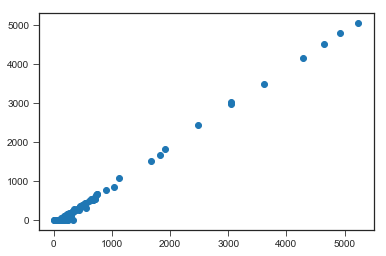

In [62]:
plt.scatter(master_list[0],outcomes[0][0])
print(np.sum(master_list[0]),np.sum(outcomes[0][0]))

In [129]:
fwd_primer_list = list(real_pair.keys())
rev_primer_list = list(real_pair['P104'].keys())
corrected_df = p.DataFrame()
for bc in range(len(outcomes)):
    this = {}
    this['barcode'] = bb2['barcode'].values[bc]
    for f in range(len(fwd_primer_list)):
        for r in range(len(rev_primer_list)):
            name = primer_indices[primer_indices['FwdPrimer'].isin([fwd_primer_list[f]]) & primer_indices['RevPrimer'].isin([rev_primer_list[r]])]['Sample'].values[0]
            this[name] = outcomes[bc][0][f][r]
    corrected_df = corrected_df.append(this,ignore_index=True)

In [98]:
primer_indices[primer_indices['FwdPrimer'].isin([fwd_primer_list[f]]) & primer_indices['RevPrimer'].isin([rev_primer_list[r]])]

,Sample,FwdPrimer,RevPrimer
0,B3-DE1,P104,P101


In [136]:
corrected_total

[array([[ 7573771.66889922,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ],
        [       0.        ,  2967080.91186094,        0.        ,
          6382326.82727912,  5678424.84185463,  2345904.73508889,
          1888453.50935598,   563169.00766168],
        [       0.        ,        0.        ,  1909027.20454639,
                0.        ,   779009.41577203,  1886155.99040409,
          2166835.68317893,   651645.1451385 ],
        [       0.        ,   283522.18040012,   571966.62003463,
          4614815.5408063 ,        0.        ,  2384942.11994608,
          1544441.42867699,   455639.61559744],
        [       0.        ,   410652.02259926,   439084.77982548,
          1978666.496368  ,  6526171.33980339,        0.        ,
          1454065.89417403,   572828.85815726],
        [       0.        ,   369234.76364134,   606677.75863222,
           673643.90324037,   8080

In [130]:
corrected_df

,B0-DE1,B0-DE2,B0-DE2b,B0-DE2c,B0-DE3,B0-DE4,B1-DE1,B2-DE1,B2-DE1b,B2-DE2,...,Z0-DE1,Z0-DE2,Z1-DE1,Z2-DE1,Z2-DE1b,Z2-DE2,Z3-DE1,Z4-DE1,Z4-DE2,barcode
0,4820.700245,3002.340093,0.0,233.187112,0.0,117.767478,549.920616,3512.507152,341.974801,5097.413000,...,276.545611,587.575627,670.140456,136.117471,122.441417,74.270336,84.763256,153.615107,179.413688,53.0
1,132915.807574,84353.620721,0.0,10105.314171,0.0,3327.710244,45385.510892,402226.517091,63442.530123,539961.593362,...,35732.797632,51525.023332,43307.390569,74823.778358,31978.792649,40189.836520,8494.874030,280900.091057,256569.263881,151.0
2,3149.962644,2270.777801,0.0,178.733862,0.0,92.363406,388.417579,2226.366793,216.696020,2628.884560,...,187.144126,379.984769,534.449205,73.489723,55.310772,22.250913,36.612905,88.713663,115.213693,262.0
3,27637.584255,17037.489952,0.0,2174.602609,0.0,791.306588,7647.811443,60304.488565,8296.794324,97942.321261,...,4816.523768,8005.301936,7609.376506,9221.215796,8328.424726,9099.118120,1771.841436,23009.910401,21806.289385,273.0
4,13191.857923,8324.090553,0.0,472.501850,0.0,186.379565,2328.921592,26672.992916,2275.117739,30235.210428,...,1364.799653,2389.974264,2414.919605,2140.012923,650.194792,897.523183,276.922650,5166.348059,4995.096781,323.0
5,25861.966615,14806.192228,0.0,1718.052519,0.0,449.891376,7433.784136,71617.939860,10413.811285,103798.621712,...,4685.346895,6692.777562,5422.835343,10940.235811,7367.471354,8681.720299,1775.319198,30644.304486,27314.204817,415.0
6,3637.838618,2248.018651,0.0,135.728478,0.0,88.148272,374.887498,2695.074919,196.677961,3295.571642,...,186.062680,372.633599,444.156295,97.890213,62.643178,31.909169,42.800332,105.853311,100.625239,622.0
7,7445.363166,4613.091582,0.0,673.907993,0.0,177.292473,2631.637120,20183.946382,3854.508461,31669.944947,...,1600.812023,2387.057150,1866.852729,4078.267009,3517.943530,3585.638633,831.862650,12424.931536,11077.978923,689.0
8,4505.685695,2777.192007,0.0,178.929866,0.0,62.963795,499.625859,3179.943318,246.958295,4502.631204,...,175.076886,387.784971,590.210459,102.487256,67.794993,45.061400,50.515228,108.895406,132.414990,697.0
9,1.807758,16.902930,0.0,1.776085,0.0,4.862469,-0.044521,1.911520,-0.081820,-0.112671,...,0.784788,-0.318453,-0.097359,-0.116031,1.894912,-0.069573,-0.076194,-0.071206,-0.108979,1185.0


In [ ]:
nonzero_indices = [i for i in range(len(np.asarray(pair_list).ravel())) if np.asarray(pair_list).ravel()[i]]
bcs = len(master_list)
rows = len(real_pair.keys())
columns = len(real_pair['P104'].keys())
x = master_list
y = master_list
rate = 0.05
flat_x = ravel_x(x,rate,rows,columns,bcs,nonzero_indices)
print(flat_x)
outcome2 = scipy.optimize.minimize(correction,flat_x,args=(y,rows,columns,bcs,nonzero_indices))

[[25728.   336.   344.   614.   466.   608.   601.   466.]
 [  434.  9873.  1403. 27516. 25381.  7697.  6149.  3105.]
 [  344.   871.  5690.  1508.  4019.  6252.  6635.  2605.]
 [  333.  1150.  2589. 16479.  1320.  7853.  4890.  1895.]
 [  382.  1783.  2313.  8070. 27563.  2301.  4954.  2328.]
 [  496.  1680.  2993.  3463.  4468. 39570.  1918.  1503.]
 [  443.  1599.  1368.  2964.  3334.  3415. 22694.  2937.]
 [  332.   859.  1458.  2929.  2904.  3876.  3233. 26604.]
 [  289.  1012.  1137.  3428.  2603. 16278.  2739.  1133.]
 [  303.   442.   420.   860.   765.  5398.  4406.   537.]
 [   55.   218.   247.  1703.  3075.   435.   401.   271.]
 [   65.   443.  1573.   291.   287.   327.   301.   177.]]
[[4726.   79.   80.  146.   82.  119.  104.   86.]
 [  87. 8192.  496. 9211. 2993.  938.  697. 1384.]
 [  84.  352. 4797.  463.  619. 1340.  670. 1368.]
 [ 101.  916. 1220. 5813.  292. 1851.  500. 1108.]
 [  84. 1082.  891. 3089. 3143.  587.  468. 1425.]
 [  92. 1085. 1181. 1279.  643. 7070

  1.100e+01]]
[[31767.   392.   464.   667.   482.   692.   743.   526.]
 [  465.  8822.  1755. 24055. 36695. 13845. 10784.  2987.]
 [  401.   887.  6026.  1562.  4457.  6197.  9219.  2724.]
 [  324.  1164.  2331. 19931.  1476.  7050.  8075.  2142.]
 [  450.  1794.  2489.  7282. 41845.  2642.  8372.  2498.]
 [  507.  1453.  2823.  2654.  4747. 38920.  2273.  1493.]
 [  477.  1493.  1396.  2731.  3892.  3429. 34065.  2891.]
 [  428.  1359.  1886.  3304.  4068.  5005.  6898. 45554.]
 [  271.   711.   778.  2535.  1607. 13445.  3108.  1031.]
 [  443.   560.   587.  1011.   988.  5439.  7917.   800.]
 [   69.   175.   192.  1439.  2302.   361.   435.   248.]
 [   57.   283.  1269.   244.   228.   312.   349.   201.]]
[[ 8.  0.  1.  0.  2.  1.  0.  0.]
 [ 0. 10.  1. 19. 14.  3.  3.  4.]
 [ 1.  2.  7.  2.  1.  8.  5.  5.]
 [ 0.  3.  3.  4.  0.  5.  3.  1.]
 [ 1.  0.  1.  3. 10.  2.  4.  0.]
 [ 0.  2.  3.  6.  6. 10.  4.  4.]
 [ 1.  3.  1.  4.  1.  2.  4.  7.]
 [ 0.  1.  2.  0.  2.  4.  2.  6

[[2495.   36.   48.   56.   34.   54.   40.   40.]
 [  38. 3668.  191. 3274. 1284.  399.  273.  508.]
 [  28.  162. 2517.  196.  245.  558.  268.  610.]
 [  35.  321.  501. 2685.  124.  753.  180.  431.]
 [  27.  432.  372. 1229. 1334.  233.  193.  612.]
 [  44.  426.  543.  467.  245. 3122.  132.  244.]
 [  50.  335.  234.  506.  170.  402. 1951.  421.]
 [  28.  104.  204.  376.  143.  362.  143.  798.]
 [  37.  251.  264.  176.  141. 2838.  563.  108.]
 [  28.   50.   39.   86.   39.  600.  133.   59.]
 [   6.   35.   25.  310.   68.   37.   20.   30.]
 [  11.  143.  266.   60.   36.   49.   28.   36.]]
[[7.130e+02 9.000e+00 1.000e+01 1.200e+01 1.900e+01 9.000e+00 1.500e+01
  1.300e+01]
 [1.300e+01 2.159e+03 8.700e+01 1.210e+03 7.760e+02 1.760e+02 1.320e+02
  2.570e+02]
 [1.100e+01 7.200e+01 1.455e+03 9.300e+01 1.190e+02 1.520e+02 9.700e+01
  2.490e+02]
 [1.800e+01 2.450e+02 2.910e+02 1.114e+03 6.000e+01 1.810e+02 1.170e+02
  2.070e+02]
 [1.100e+01 2.620e+02 1.960e+02 4.630e+02 7.460

  3.000e+01]]
[[ 98.   3.   2.   3.   1.   1.   3.   2.]
 [  1. 385.   9. 203. 114.  22.  22.  47.]
 [  4.  10. 248.  16.  25.  27.  16.  40.]
 [  6.  41.  53. 147.  11.  26.  18.  38.]
 [  1.  45.  33.  58. 123.  12.  23.  45.]
 [  1.  48.  55.  31.  21.  97.  10.  25.]
 [  4.  21.  18.  31.  12.   9.  54.  25.]
 [  0.  10.  11.  16.  15.  23.  12.  64.]
 [  2.  24.  24.  26.  20. 291.  58.  16.]
 [  1.   3.   6.   4.   2.  14.  11.   3.]
 [  0.   2.   0.  16.  12.   0.   4.   1.]
 [  0.  11.  26.   5.   3.   7.   2.   3.]]
[[ 932.   24.   30.   33.   16.   23.   18.   15.]
 [  29. 2785.  148. 2059. 1041.  267.  200.  373.]
 [  18.   96. 1763.  109.  204.  196.  161.  326.]
 [  29.  290.  344. 1548.   80.  267.  166.  268.]
 [  25.  371.  252.  621. 1041.  152.  141.  410.]
 [  17.  305.  332.  250.  210. 1024.   94.  167.]
 [  24.  149.  161.  231.  114.  133.  620.  178.]
 [  14.   83.  133.  189.  102.  187.  110.  690.]
 [  14.  196.  199.  151.  137. 2382.  444.   87.]
 [   9.   

In [117]:
corrected, rate = unravel_x(outcome2.x,rows,columns,bcs,nonzero_indices)

([array([[25450.26567875,     0.        ,     0.        ,     0.        ,
              0.        ,     0.        ,     0.        ,     0.        ],
         [    0.        ,  9118.30007286,     0.        , 26502.99747913,
          24278.8710416 ,  6271.5010807 ,  5027.09606332,  2072.60662375],
         [    0.        ,   524.04037322,  5387.84277233,     0.        ,
           3205.49780022,  5307.08397096,  6012.28280969,  2062.2944349 ],
         [    0.        ,   720.58583305,  2171.80609501, 15768.98073568,
              0.        ,  6838.3684164 ,  4165.31615672,  1260.29417985],
         [    0.        ,  1252.16040007,  1785.62025941,  7171.39711471,
          26783.74229408,     0.        ,  4122.41145379,  1589.94396162],
         [    0.        ,  1089.16560162,  2413.16447885,  2461.00071662,
           3407.13457378, 38694.49709082,     0.        ,   697.97682244],
         [    0.        ,  1148.29718943,   913.41824772,  2098.09716666,
           2403.11089574,  2331.

In [134]:
print(np.sum(master_list[0]),np.sum(outcomes[0]))

61094.0 52333.97772319781


In [86]:
primer_indices
pair_list


In [91]:
primer_indices

,Sample,FwdPrimer,RevPrimer
0,B3-DE1,P104,P101
1,C1R2,P105,P101
2,C1R3,P111,P101
3,C1R4,P112,P101
4,C1R5,P122,P101
5,C1R6,P123,P101
6,C1R7,P124,P101
7,C1R8,P125,P101
8,C1R9,P130,P101
9,C1R10,P131,P101


In [143]:
print(np.sum(bb2[condition+'3-DE1']))
al = ['B1-DE1','C1-DE1','Y1-DE1','Z1-DE1','Tneg-DE1','C3-DE1','Y3-DE1','B0-DE2c','C0-DE1b','Z2-DE1b','B3-DE1b','C1-DE1b','Y1-DE1b']
print(np.sum([bb2[a].values for a in al]),0.01*np.sum([bb2[a].values for a in al]))

275487
19407931 194079.31


466


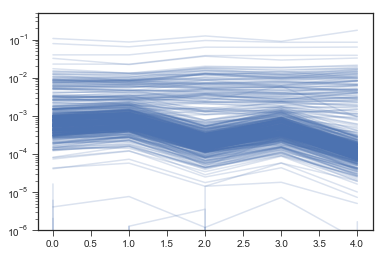

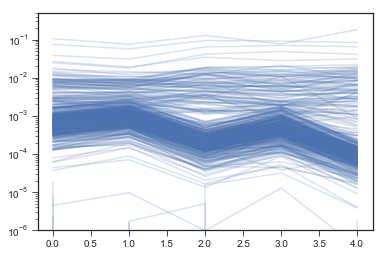

In [131]:
condition = 'Z'
lane = bb2
trajectory = [lane[condition+'0-DE1']/np.sum(lane[condition+'0-DE1']),lane[condition+'1-DE1']/np.sum(lane[condition+'1-DE1']),
              lane[condition+'2-DE1']/np.sum(lane[condition+'2-DE1']),
              lane[condition+'3-DE1']/np.sum(lane[condition+'3-DE1']),lane[condition+'4-DE1']/np.sum(lane[condition+'4-DE1'])]

plt.plot(trajectory,'b',alpha=0.2)
# this_subset = lane[lane['barcode'].isin(neutrals)]
# trajectory = [this_subset[condition+'0-DE1']/np.sum(lane[condition+'0-DE1']),this_subset[condition+'1-DE1']/np.sum(lane[condition+'1-DE1']),
#               this_subset[condition+'2-DE1']/np.sum(lane[condition+'2-DE1']),
#               this_subset[condition+'3-DE1']/np.sum(lane[condition+'3-DE1']),this_subset[condition+'4-DE1']/np.sum(lane[condition+'4-DE1'])]
# plt.plot(trajectory,'r',alpha=1.0)


plt.yscale('log')
plt.ylim(10**-6,0.5)
plt.figure()
lane = corrected_df
trajectory = [lane[condition+'0-DE1']/np.sum(lane[condition+'0-DE1']),lane[condition+'1-DE1']/np.sum(lane[condition+'1-DE1']),
              lane[condition+'2-DE1']/np.sum(lane[condition+'2-DE1']),
              lane[condition+'3-DE1']/np.sum(lane[condition+'3-DE1']),lane[condition+'4-DE1']/np.sum(lane[condition+'4-DE1'])]

plt.plot(trajectory,'b',alpha=0.2)
# this_subset = lane[lane['barcode'].isin(neutrals)]
# trajectory = [this_subset[condition+'0-DE1']/np.sum(lane[condition+'0-DE1']),this_subset[condition+'1-DE1']/np.sum(lane[condition+'1-DE1']),
#               this_subset[condition+'2-DE1']/np.sum(lane[condition+'2-DE1']),
#               this_subset[condition+'3-DE1']/np.sum(lane[condition+'3-DE1']),this_subset[condition+'4-DE1']/np.sum(lane[condition+'4-DE1'])]
# plt.plot(trajectory,'r',alpha=1.0)


plt.yscale('log')
plt.ylim(10**-6,0.5)
print(len(trajectory[0]))

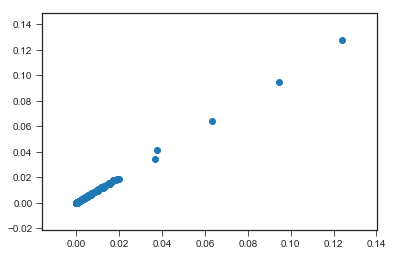

In [133]:
plt.scatter(bb2[condition+'2-DE1']/np.sum(bb2[condition+'2-DE1']),corrected_df[condition+'2-DE1']/np.sum(corrected_df[condition+'2-DE1']))

In [145]:
bb1.columns

Index(['barcode', 'B3-DE1', 'B3-DE1_none', 'B3-DE1_onlyfwd', 'B3-DE1_onlyrev',
       'C2R1', 'C2R1_none', 'C2R1_onlyfwd', 'C2R1_onlyrev', 'C3R1',
       ...
       'C6R12_onlyfwd', 'C6R12_onlyrev', 'C7R12', 'C7R12_none',
       'C7R12_onlyfwd', 'C7R12_onlyrev', 'C8R12', 'C8R12_none',
       'C8R12_onlyfwd', 'C8R12_onlyrev'],
      dtype='object', length=385)

In [152]:
print(bb1['B0-DE1'].values[1],bb1['B0-DE1'].values[1]/np.sum(bb1['B0-DE1'].values),bb1['B0-DE1'].values[1]**2/np.sum(bb1['B0-DE1'].values*10**9))

90363 0.038133721016105855 3.4458774321783735e-06


In [149]:
bb1['B0-DE1']

1346     4038
873     90363
212      3017
884     21351
199     11025
1168    18620
1045        0
1956     2811
142      4810
2041     3631
1163        0
384     96117
1080    14168
1511     2819
275     15762
937      1532
1869     2621
717      7881
1        6846
1989     2094
852      8722
342      5960
239      5648
955     15866
1145     2211
138      4682
257     11274
703      3879
438         0
1202     8416
        ...  
692      4012
679      2237
1817     3031
1991     6592
672      2978
529      3253
880      3415
115      2577
1165     1617
447      2209
1385     3212
2015     4614
1609     4125
1967     3896
1129     1186
489      1690
627      2135
1500     2390
1365      636
544      2160
56       4805
1352     3382
94       1571
254      1573
1606     3088
780      3372
266      1102
1495     3277
2081     1830
1217     9412
Name: B0-DE1, Length: 472, dtype: int64